## San Francisco Crime Classification
### Predict the category of crimes that occurred in the city by the bay


![Getting Started](sf1.jpg)

Image: https://unsplash.com/@mvdheuvel
  

From Sunset to SOMA, and Marina to Excelsior, this competition's dataset provides nearly 12 years of crime reports from across all of San Francisco's neighborhoods. Given time and location, you must predict the category of crime that occurred.

In [36]:
#
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from matplotlib import rcParams

%config InlineBackend.figure_format = 'retina'
sns.set_style("white")
rcParams['figure.figsize'] = (6,3)
import matplotlib.ticker as ticker

from sklearn.preprocessing import RobustScaler # hay outliers
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import log_loss

In [37]:
path = r"C:\Users\gonza\OneDrive\Documentos\datascience-thebridge-master\ejercicios gonzalo\DATA\sf-crime"
file = "train.csv"
# change astype to np.float32 to reduce memory usage
df = pd.read_csv(os.path.join(path,file),dtype={"X":np.float32,"Y":np.float32})

In [38]:
df.head(3)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425888,37.774597
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425888,37.774597
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424362,37.800415


In [39]:
# remove duplicates
print(df.duplicated(keep=False).value_counts())
df = df.drop_duplicates()

False    873688
True       4361
dtype: int64


In columns X and Y there seem to be outliers (Y = 90.0000); it seems that this event belongs to another location. So we will remove it !

In [40]:
df[["X","Y"]].describe()

,X,Y
count,875726.000000,875726.000000
mean,-121.901985,37.958752
std,0.521390,0.494508
min,-122.513641,37.707878
25%,-122.432953,37.752426
50%,-122.416443,37.775421
75%,-122.406960,37.784378
max,-120.500000,90.000000


Now let's see some information about the non-numeric columns.
The most repeated category is LARCENY/THEFT; Fridays seem to be quite entertaining and in SOUTHERN I don't think they get bored. 	

In [41]:
df.describe(include="object")

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address
count,875726,875726,875726,875726,875726,875726,875726
unique,389257,39,879,7,10,17,23228
top,2011-01-01 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,SOUTHERN,NONE,800 Block of BRYANT ST
freq,185,174320,59765,133371,156528,525122,26245


We are going to extract information from the columns Date and Adress; for example we can have columns like Year, Month, DayofWeek,Weekend,Minute; and from Adress the cases happen either in a street (ST) or block (Block), so we can create a column called "Block".	

We will also use LabelEncoder to transform the "Category" and "PdDistrict" columns.

In [42]:
def convert_dataframe(df):
    """
    remove outliers and create time and block columns. Convert to np.int32 
    due to memory usage
    """
    
    # time columns
    df["Dates"] = pd.to_datetime(df["Dates"],infer_datetime_format=True)
    df["Year"] = df["Dates"].dt.year.astype(np.int32)
    df["Month"] = df["Dates"].dt.month.astype(np.int32)
    df["Day"] = df["Dates"].dt.day.astype(np.int32)
    df["Hour"] = df["Dates"].dt.hour.astype(np.int32)
    df["Minute"] = df["Dates"].dt.minute.astype(np.int32)
    df["Day_week_numeric"] = df["Dates"].dt.dayofweek.astype(np.int32)
    df["Weekend"]= np.where((df["Day_week_numeric"] >= 4) & (df["Day_week_numeric"] <=6),1,0)
    # create block column from Adress column
    df["Block"] = df.Address.str.contains("Block").astype(np.int32)
    return df

In [43]:
df_date = convert_dataframe(df)

In [44]:
# label encoder Category and PdDistrict
def label_dataframe(df):
    label = LabelEncoder()
    df["Category_encode"] = label.fit_transform(df.Category)
    df["PdDistric_encode"] = label.fit_transform(df.PdDistrict)
    return df

In [45]:
df_label = label_dataframe(df_date)

In [46]:
df_label.head(3)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Year,Month,Day,Hour,Minute,Day_week_numeric,Weekend,Block,Category_encode,PdDistric_encode
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425888,37.774597,2015,5,13,23,53,2,0,0,37,4
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425888,37.774597,2015,5,13,23,53,2,0,0,21,4
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424362,37.800415,2015,5,13,23,33,2,0,0,21,4


In [47]:
# remove outliers
df_outliers = df_label.loc[df.Y < 90.].copy()

### EDA
We have already prepared the dataframe, so now we can do an exploratory analysis to see what information we can obtain.

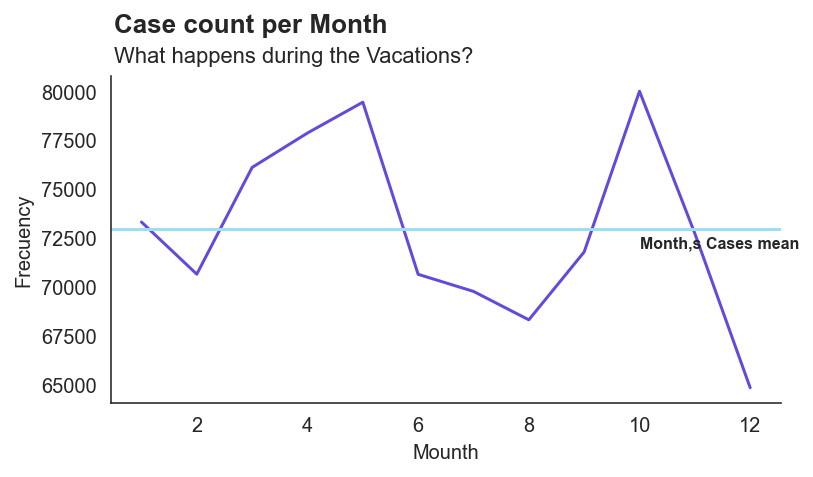

In [69]:
# count values (we can use value_counts() as well)
month_count = df_outliers.groupby(["Month"])["Dates"].count().reset_index()
# lineplot
ax = sns.lineplot(x="Month",y="Dates",data=month_count,color="#6549DA")
# add horizontal line
ax.axhline(month_count['Dates'].mean(),color="#9CDEF6")
sns.despine()
# adding text
ax.text(0.5,83000,"Case count per Month",
        fontsize=13,        
         fontweight='bold') 
ax.text(0.5,81500,"What happens during the Vacations?",
        fontsize=11)
ax.text(10,72000,"Month,s Cases mean",
        fontsize=8,        
         fontweight='bold')
plt.xlabel("Mounth")
plt.ylabel("Frecuency")
# so only the graphic appears without any text referring to the object type.
plt.show(block=False)

At first glance, it seems that during the summer and Christmas months the number of cases is below the monthly average.

Let's do the same but with the days of the week to see if we can see any difference.
We can see that cases go up a bit during Wednesdays and Fridays; Sundays are quieter. 

The graph may be misleading and show that there is a big difference between the days, but the range is only between 132500 and 117500 (Day of Week) and 80000-65000 (Month).

Many will think it is common sense that during the vacation months and Sundays there are fewer cases, but it never hurts to show it in a graph.

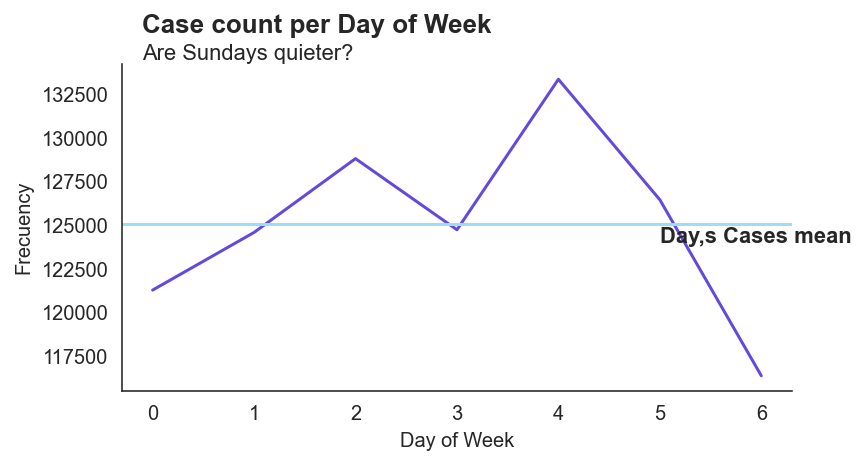

In [68]:
day_count = df_outliers.groupby(["Day_week_numeric"])["Dates"].count().reset_index()
#lineplot
ax = sns.lineplot(x="Day_week_numeric",y="Dates",data=day_count,color="#6549DA")
# add horizontal line
ax.axhline(day_count['Dates'].mean(),color="#9CDEF6")
sns.despine()
# add text
ax.text(-0.1,136000,"Case count per Day of Week",
        fontsize=13,        
         fontweight='bold') 
ax.text(-0.1,134500,"Are Sundays quieter?",
        fontsize=11)
ax.text(5,124000,"Day,s Cases mean",
        fontsize=11,        
         fontweight='bold')
# axis title
plt.xlabel("Day of Week")
plt.ylabel("Frecuency")
# so only the graphic appears without any text referring to the object type.
plt.show(block=False)

It is not surprising that, if we graph the cases by time of day, we see that during the night there are fewer cases.

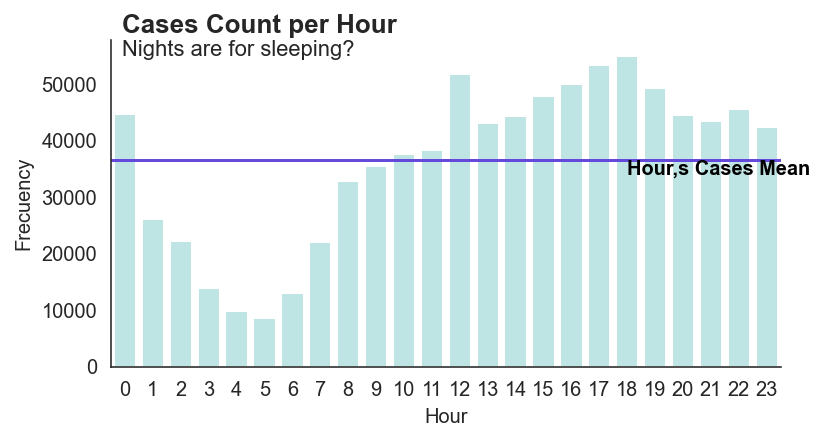

In [67]:
hour_count = df_outliers.groupby(["Hour"])["Dates"].count().reset_index()
#barplot
ax = sns.barplot(y="Dates",x="Hour",data=hour_count,color="#B8EBE9")
# with axvline we can draw a vertical line
ax.axhline(hour_count["Dates"].mean(),color="#6549DA")

plt.ylabel("Frecuency")
plt.xlabel("Hour")
plt.grid(False)
sns.despine()

# add text anotation
ax.text(18,34000, "Hour,s Cases Mean", horizontalalignment='left', size='medium', color='black', weight='semibold')
ax.text(-0.1,59000,"Cases Count per Hour",
        fontsize=13,        
         fontweight='bold') 
ax.text(-0.1,55000,"Nights are for sleeping?",
        fontsize=11) 
plt.show(block=False)


Let us now see which are the most common categories, expressed as a percentage of the total,and the districts where there are more incidences.

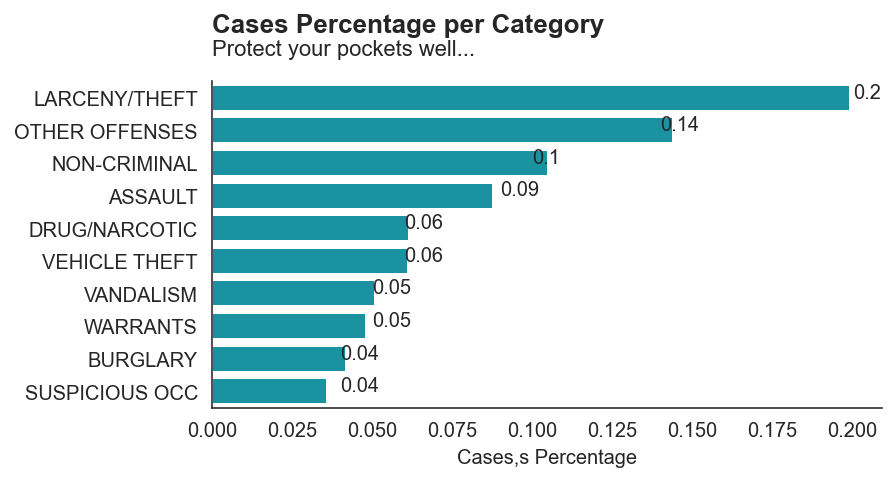

In [66]:
# dataframe
category_counts = df_outliers.Category.value_counts(normalize=True).reset_index().head(10)
#barplot
ax=sns.barplot(y="index",x="Category",data=category_counts,color="#04A4B5")

plt.ylabel("")
plt.xlabel("Cases,s Percentage")
plt.grid(False)
sns.despine()
#add text
ax.text(0,-2,"Cases Percentage per Category",
        fontsize=13,        
         fontweight='bold') 
ax.text(0,-1.3,"Protect your pockets well...",
        fontsize=11)
# with a loop I add the values to the graphic
for num,text in zip(range(10),round(category_counts["Category"],2)):
    ax.text(text,num,text)
plt.show(block=False)

Let's make a graph of cases by districts; using cumsum we can see the cumulative. We can see that 54 percent of the cases occur in only four districts.

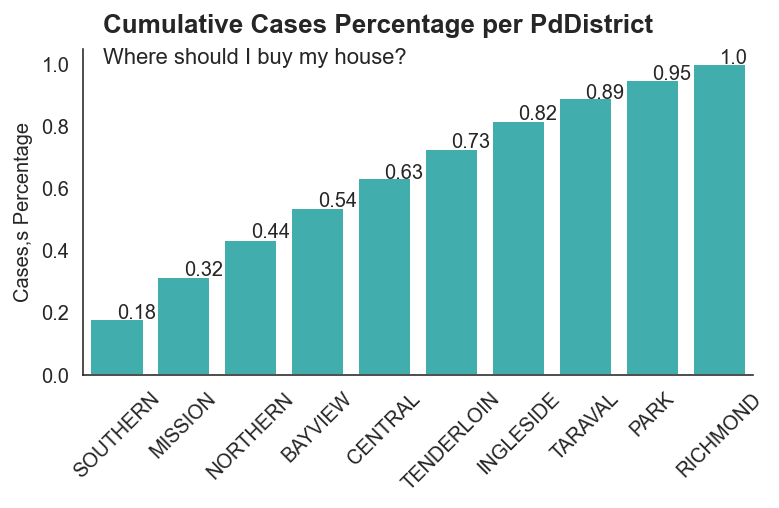

In [64]:
#Let's use cumsum to see a cumulative
distric_counts_cumsum = df_outliers.PdDistrict.value_counts(normalize=True).cumsum().reset_index()
#barplot
ax=sns.barplot(y="PdDistrict",x="index",data=distric_counts_cumsum,color="#30BFBF")

plt.ylabel( "Cases,s Percentage")
plt.xlabel("")
plt.xticks(rotation=45)
plt.grid(False)
sns.despine()
#add text
ax.text(-0.2,1.10,"Cumulative Cases Percentage per PdDistrict",
        fontsize=13,        
         fontweight='bold') 
ax.text(-0.2,1.0,"Where should I buy my house?",
        fontsize=11)
# with a loop I add the values to the graphic
for num,text in zip(range(10),round(distric_counts_cumsum["PdDistrict"],2)):
    ax.text(num,text,text)
plt.show(block=False)

Using pd.crosstab we can see by categories which are the districts where there are more incidences (using normalize="index" shows us the percentages per row).

We can see, for example, that 48 percent of the prostitution cases take place in Mission, 32 percent of the Drug cases take places in Tenderloin..



In [53]:
distric_category = pd.crosstab(columns=df_outliers["PdDistrict"],index=df["Category"],normalize="index")
category_district_max = pd.concat([distric_category.idxmax(axis=1),distric_category.max(axis=1)],axis=1).sort_values(by=1,ascending=False).reset_index()
category_district_max.columns = ["Category","District","Percentage"]
category_district_max.head(10)

,Category,District,Percentage
0,TREA,BAYVIEW,0.500000
1,PROSTITUTION,MISSION,0.486570
2,LOITERING,SOUTHERN,0.342171
3,DRUG/NARCOTIC,TENDERLOIN,0.327677
4,FAMILY OFFENSES,MISSION,0.284836
5,LIQUOR LAWS,MISSION,0.260664
6,ARSON,BAYVIEW,0.259921
7,DISORDERLY CONDUCT,MISSION,0.254465
8,RUNAWAY,PARK,0.247624
9,LARCENY/THEFT,SOUTHERN,0.238983


We can also see by districts and weekends (Friday-Sunday); it strikes me that Tinderloin, where 32 percent of the drug cases occur there, the weekends are quieter.

In [54]:
pd.crosstab(index=df_outliers.PdDistrict,columns=df_outliers.Weekend,normalize="index")

Weekend,0,1
PdDistrict,,
BAYVIEW,0.574246,0.425754
CENTRAL,0.535913,0.464087
INGLESIDE,0.580553,0.419447
MISSION,0.572276,0.427724
NORTHERN,0.562226,0.437774
PARK,0.570597,0.429403
RICHMOND,0.571606,0.428394
SOUTHERN,0.564017,0.435983
TARAVAL,0.579791,0.420209


In [80]:
df_outliers[["X","Y"]].describe()

,X,Y
count,875659.000000,875659.000000
mean,-121.902130,37.954769
std,0.521108,0.189255
min,-122.513641,37.707878
25%,-122.432953,37.752426
50%,-122.416443,37.775421
75%,-122.406960,37.784378
max,-122.364937,37.819977


### Model
I could go on and on analyzing the cases for example by year, by resolution, focusing on a category (see scatter below) etc... but let's go directly to the model.



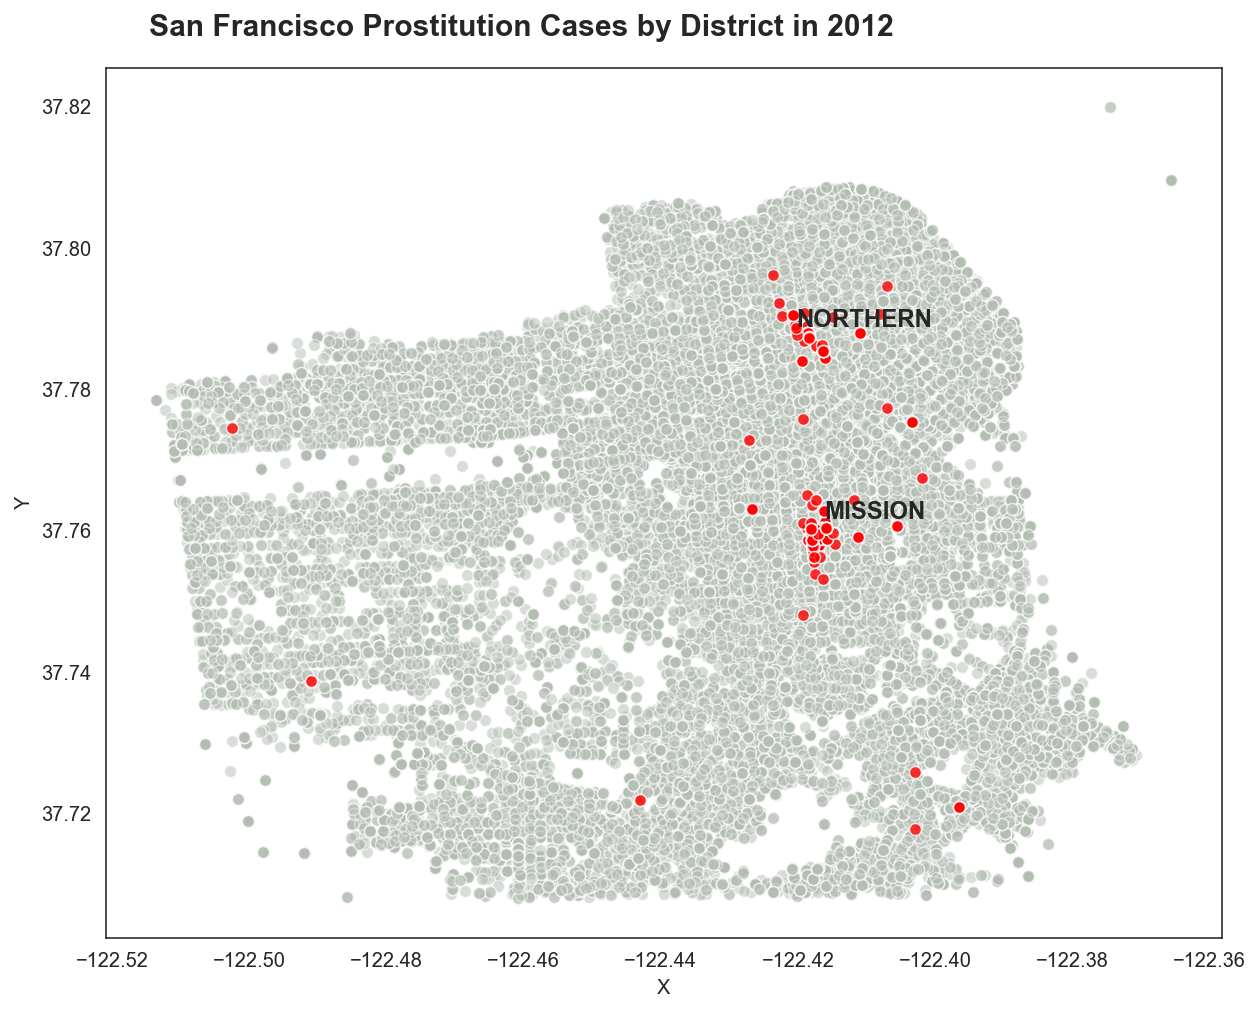

In [100]:
plt.figure(figsize=(10,8))
sns.scatterplot(x="X",y="Y",data=df_outliers.loc[df_outliers.Year==2012],alpha=0.5,color="#B3BDB2")
sns.scatterplot(x="X",y="Y",data=df_outliers.loc[(df_outliers.Year==2012)&(df_outliers.Category=="PROSTITUTION")],alpha=0.8,color="r")


#add text
plt.text(-122.514741,37.829977,"San Francisco Prostitution Cases by District in 2012",
        fontsize=15,        
         fontweight='bold') 
plt.text(-122.416145,37.761631,"MISSION",
        fontsize=12,        
         fontweight='bold') 
plt.text(-122.420296,37.788879,"NORTHERN",
        fontsize=12,        
         fontweight='bold') 


plt.show(block=False)



For this, the first thing I am going to do, using Kmeans, is to create a new feature that can help to improve the predictions.

In [57]:
X = df_outliers.drop(["Dates","Category","Descript","DayOfWeek","PdDistrict","Resolution","Address","Category_encode"],axis=1).copy()
y = df_outliers["Category_encode"]

def kmean_predict(df):
    transformer = RobustScaler()
    df_norma = transformer.fit_transform(df)
    kmeans = KMeans(n_clusters=6,random_state=0)
    return kmeans.fit_predict(df_norma)  

In [58]:
X["Cluster"]= kmean_predict(X)

In [ ]:

X_train, X_val, y_train, y_val = train_test_split(df_copy_kmean, y, test_size = 0.25, random_state = 21)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)



# Fitting Random Forest Classification to the Training set
classifier = RandomForestClassifier( n_jobs = -1,random_state =50,max_depth=10,max_features="auto",min_samples_split=4)
classifier.fit(X_train, y_train)

In [ ]:
# predict
predict_proba = classifier.predict_proba(X_val)
log_loss(y_val,predict_proba)